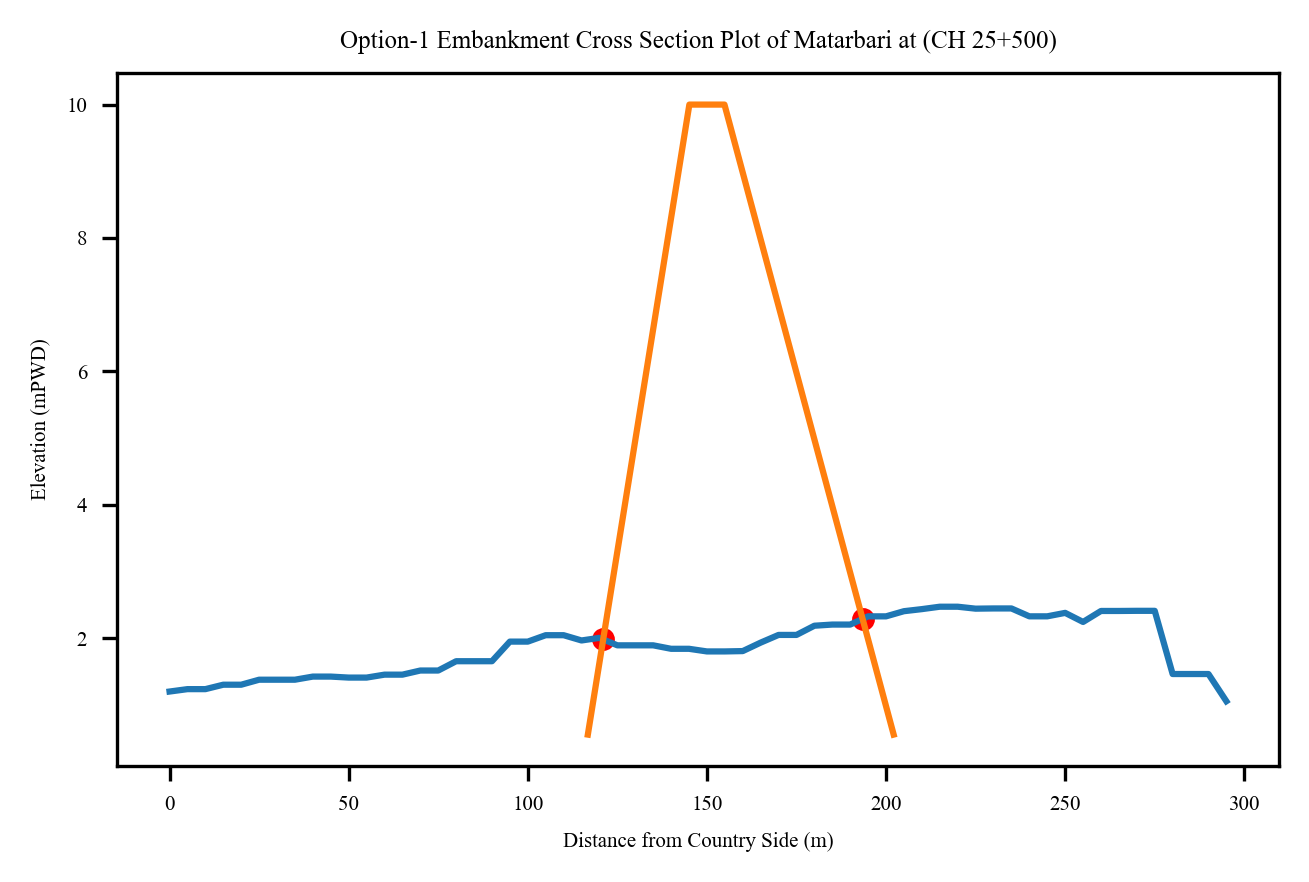

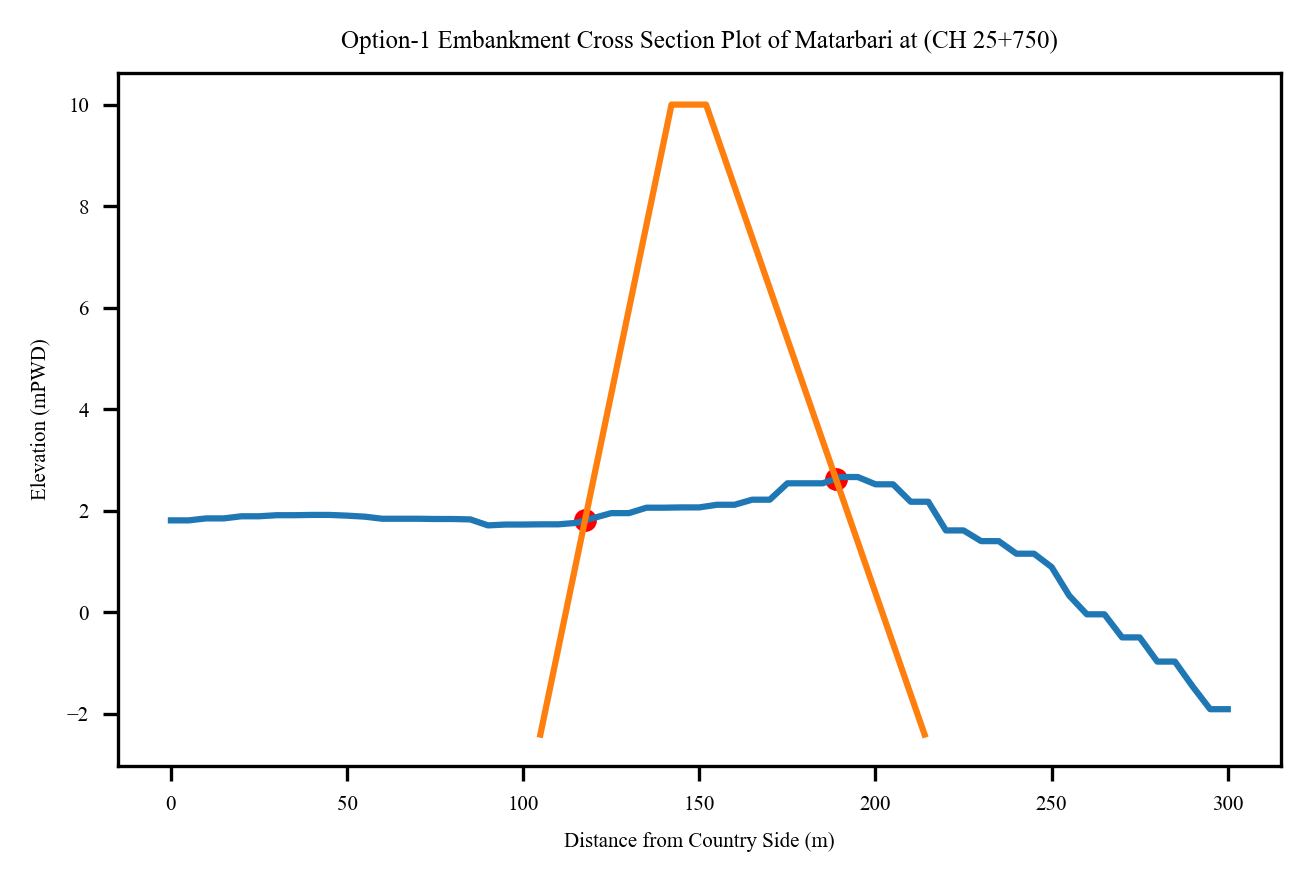

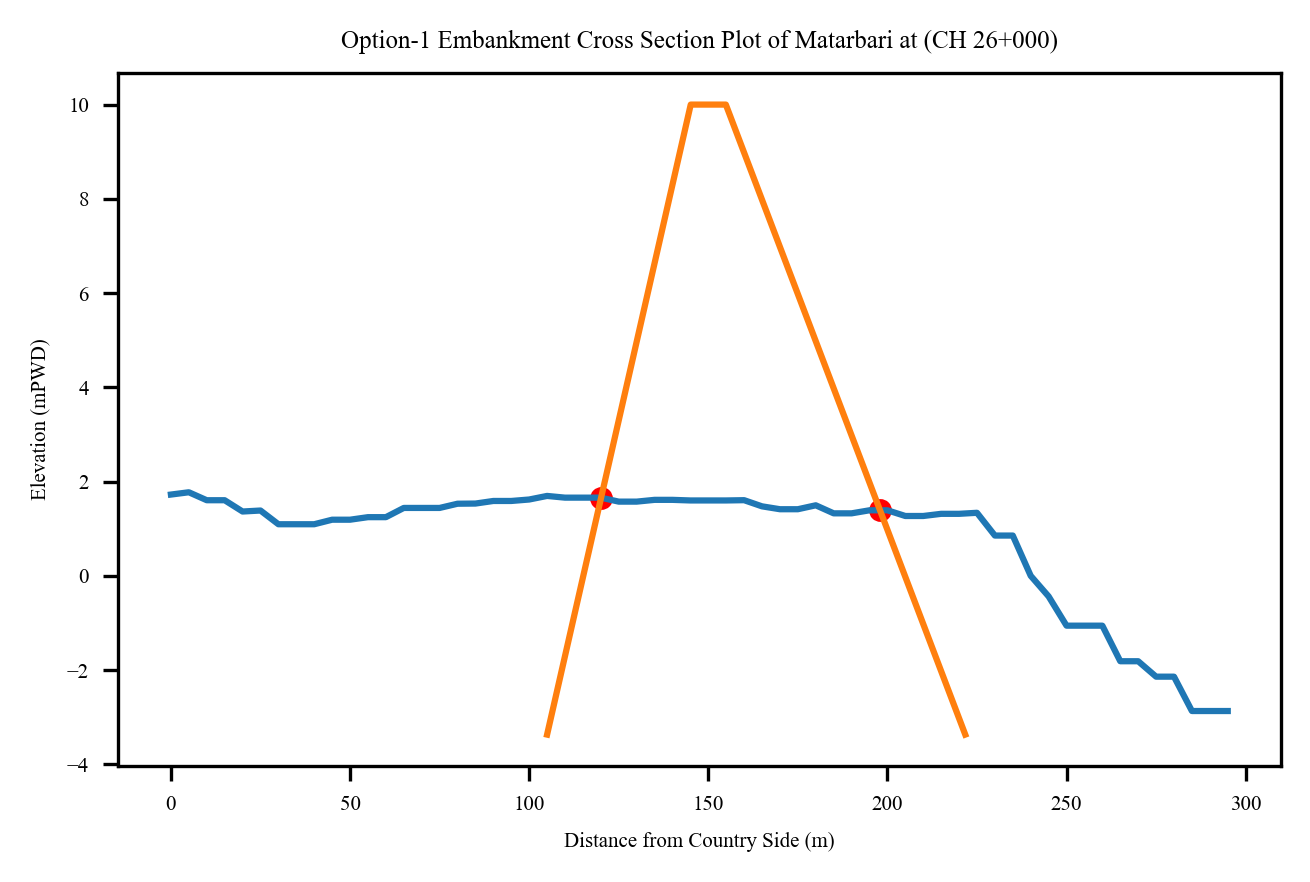

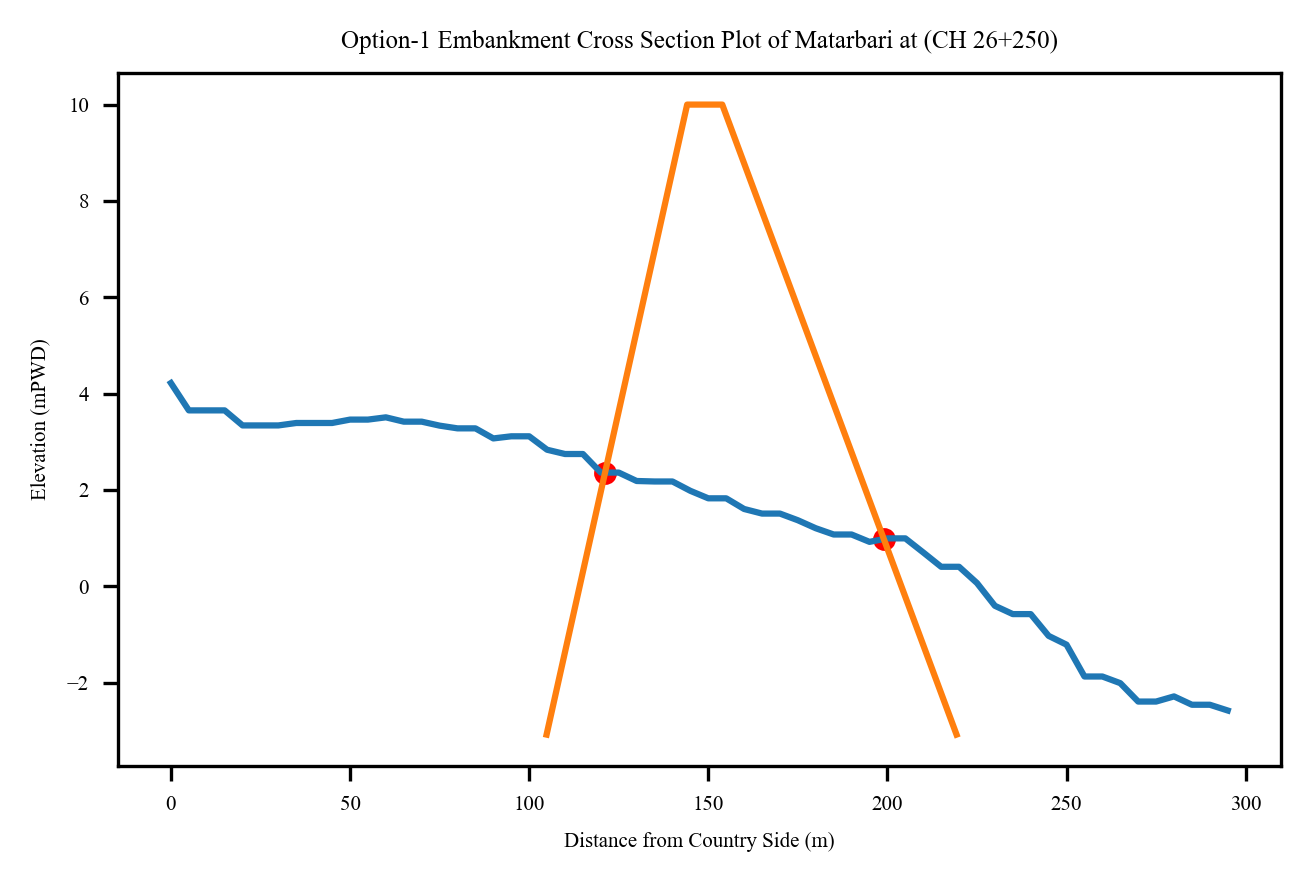

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os


# Defining a function to convert the chainage format to conventional number format
def chainage_format(num):
    q = str(int(num))
    if len(q) == 1:
        return '00+00{}'.format(q)
    elif len(q) == 2:
        return '00+0{}'.format(q)
    elif len(q) == 3:
        return '00+{}'.format(q)
    elif len(q) == 4:
        return '0{}+{}'.format(q[0], q[1:])
    else:
        return '{c}+{d}{e}{f}'.format(c=q[:-3], d=q[-3], e=q[-2], f=q[-1])


# Reading the file containing existing ground level (transverse to the embankment alingnment [cross section])
# and specifying the embankment chainage field name in the file
n_df = pd.read_excel("E:\Script\Embankment_Right_of_Way\Input\Cross_Section_Data.xlsx")

unique_field = 'Chainage'
xns_dist_column = 'Distance (m)'
land_level_field = 'RL_mPWD'

# Reading the embankment related information file
# And specifying the center line distance from the cross section starting point
# Also setting the embankment crest width, design crest level, river side and country side slope field name
cl_df = pd.read_excel(r"E:\Script\Embankment_Right_of_Way\Input\Center_Line_Distance_From_CS.xlsx")

cl_dist_field = 'CL_Distance'
crest_width_field = 'Crest_Width (m)'
design_crest_level_field = 'DCL_RL'
country_side_slope_field = 'CS_Slope'
river_side_slope_field = 'RS_Slope'

# Setting the output folder path
output_path = r'E:\Script\Embankment_Right_of_Way\Ouput'

# Defining a blank dataframe to store the chainage wise
# country side and river side toe intersecting point distance and ground level info
# from the embankment cross section starting point
r_df = pd.DataFrame()

# Iterating through the each emabankment chainage field to find the toe intersecting point
for chainage in n_df[unique_field].unique():

    # Grouping all the cross-section data by chainage, getting the chainage wise
    # and conveting the chaiange number to the conventional chainage format using the defined function
    gr = n_df.groupby(unique_field)
    df = gr.get_group(chainage)
    chainage_txt = chainage_format(chainage)

    # Setting the specific chainage embankment information
    cl_point = ((cl_df[cl_df[unique_field] == chainage][cl_dist_field]).values)[0]
    crest_width = ((cl_df[cl_df[unique_field] == chainage][crest_width_field]).values)[0]
    design_crest_level = ((cl_df[cl_df[unique_field] == chainage][design_crest_level_field]).values)[0]
    cs_slope = ((cl_df[cl_df[unique_field] == chainage][country_side_slope_field]).values)[0]
    rs_slope = ((cl_df[cl_df[unique_field] == chainage][river_side_slope_field]).values)[0]

    # CREATING A DESIGN EMBANKMENT TEMPLATE CROSS SECTION

    # Finding the lowest level in the cross-section data and suntracting 0.5m from that to ensure that
    # existing ground level line and embankment design section line intersects
    lowest_RL = df[land_level_field].min() - 0.5

    # Calculating the distance of design embankment cross-section template country furthest point from CL
    cs_toe_dist = cl_point - ((design_crest_level - lowest_RL) * (cs_slope) + (crest_width / 2))

    # Calculating the country side crest level distance from embankment center line(CL)
    cs_crest_dist = cl_point - (crest_width / 2)

    # Calculating the river side crest level distance from embankment center line(CL)
    rs_crest_dist = cl_point + (crest_width / 2)

    # Calculating the distance of design embankment cross-section template riverside furthest point from CL
    rs_toe_dist = cl_point + ((design_crest_level - lowest_RL) * (rs_slope) + (crest_width / 2))

    # Creating distance and its correspondig reduced level(RL) list
    d_distance = [cs_toe_dist, cs_crest_dist, cl_point, rs_crest_dist, rs_toe_dist]
    d_RL = [lowest_RL, design_crest_level, design_crest_level, design_crest_level, lowest_RL]

    # FINDING THE INTERSECTING POINTS OF EXISTING GROUND LEVEL AND EMBANKMENT DESIGN TEMPLATE

    # Creatind two line using the embankment cross-section data and design embankment template section information
    # and finding the intersecting points of these two lines
    first_line = LineString(np.column_stack((df[xns_dist_column], df[land_level_field])))
    second_line = LineString(np.column_stack((d_distance, d_RL)))
    intersection = first_line.intersection(second_line)

    # FINDING THE COUNTRY SIDE AND RIVER SIDE TOE FROM THE INTERSECTING POINTS

    # Defining two empty list to store the intersecting points and its corresponding elevation value
    inter_x = []
    inter_y = []

    # Looping through all the intersecting points and updating the distance and Rl list
    for point in intersection.geoms:
        inter_x.append(point.x)
        inter_y.append(point.y)

    # Creating a dataframe using the intersecting points distance and RL information list and
    # adding the corresponding embankment chainage column into the dataframe
    inter_df = pd.DataFrame({'Chainage (m)':chainage, "Distance from Start Point (m)": inter_x, "RL (mPWD)": inter_y})

    # Finding the country side toe and adding the remarks
    cst_df = inter_df.nsmallest(1, "Distance from Start Point (m)")
    cst_df['Remarks'] = 'CS Toe'

    # Finding the river side toe and adding the remarks
    rst_df = inter_df.nlargest(1, "Distance from Start Point (m)")
    rst_df['Remarks'] = 'RS Toe'

    # Updating the toe information into the chainage toe information dataframe
    r_df = pd.concat([r_df, cst_df, rst_df])

    # PLOTTING THE EXISTING LAND LEVEL, EMBANKMENT DESIGN SECTION TEMPLATE AND TOE POINTS

    # Defining plot font family, weight and size
    font = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 5}

    # Setting the axis tick label size and figure size
    plt.rc('font', **font)
    plt.rc('xtick', labelsize=5)
    plt.rc('ytick', labelsize=5)

    plt.figure(figsize=(5, 3), dpi=300)

    # Plotting the existing embankment cross-section
    plt.plot(df[xns_dist_column], df[land_level_field], '-')

    # Adding the design embankment cross-section template into the plot
    plt.plot(d_distance, d_RL, '-')

    # Adding emabankment toe points into the plot
    plt.scatter(inter_x, inter_y, c='red', s=20)

    # Setting the plot title, x-axis and y-axis label
    plot_title = 'Option-1 Embankment Cross Section Plot of Matarbari at (CH {a})'.format(a=chainage_txt)
    plt.title(plot_title)
    plt.xlabel('Distance from Country Side (m)')
    plt.ylabel('Elevation (mPWD)')

    # Saving the plotted figure
    file_path = os.path.join(output_path, '{}.jpg'.format(chainage_txt))
    plt.savefig(file_path,bbox_inches='tight', dpi=300)

# Saving the chainage embankment cross-section toe dataframe
r_df.to_excel(os.path.join(output_path, "Option_1_Toe_Points_from_CS.xlsx"), index=False, float_format='%.2f')